![sutd](sutd.png)
## <center>50.040 Natural Language Processing, Summer 2022<center>
<center>**Homework 3**

<center>**Due 29 July 2022, 5pm** <center>

**Write your student ID and name**

ID: 1004365

Name: Lee Jet Xuen

Students whom you have discussed with (if any):    
Brandon Chong 1004104      
Tay Sze Chang 1004301

### Requirements:
- Use Python to complete this homework.
- Follow the honor code strictly.

In this homework, we'll implement ``IBM Model 1`` using the ``expectation-maximization (EM)`` algorithm. We need to estimate the  translation probabilities  $t(f|e)$ on a parallel corpus, where $e$ is a word from the English sentences and $f$ is a word from the corresponding foreign sentences. 

Note that there's a constraint for such probabilities:
$$\sum_f t(f|e)=1,  \ \ \ t(f|e)\geq 0 \ \quad (1)$$

**We'll use this constraint when initializing the translation probabilities in subsequent tasks.**

## Data
We'll use the English-French parallel corpus under the folder ``data/en-fr``, which contains a set of translation instances. As can be seen below each instance consists of an English-French sentence pair (note that we are translating from French into English, but as we discussed in class, when working on the translation model using IBM model 1, we are interested in generating French from English).



    Hop in.	Montez.
    Hug me.	Serre-moi dans tes bras !
    I left.	Je suis parti.

The dataset is obtained from [MXNET](http://data.mxnet.io/data/fra-eng.zip). Please run the provided code below to obtain the preprocessed English sentences and French sentences. Do not perform any further preprocessing. 


In [1]:
import seaborn as sns
import numpy as np
from time import time
from collections import Counter, defaultdict
import itertools

from matplotlib import pyplot as plt
%matplotlib inline

# Part 1: Statistical Machine Translation \[25 points]

In [2]:
path = 'data/part1/en-fr.txt'
with open(path, 'r', encoding='utf8') as f:
    raw_text = f.read()

#Original code from 
#https://www.d2l.ai/chapter_recurrent-neural-networks
def preprocess_nmt(text):
    '''
    Arg:
        text: parallel text, string
    Return:
        out: preprocessed text, string
    '''
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: (
        True if char in (',', '!', '.') and prev_char != ' ' else False)
    out = [' '+char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text.lower())]
    out = ''.join(out)
    return out

def tokenize_nmt(text, num_examples = None):
    '''
    Args:
        text: parallel text, string
        num_examples: number of examples to be selected, int
    Returns:
        left: English sentences, list
        right: French sentences, list
    '''
    left, right = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            left.append(parts[0].split(' '))
            right.append(parts[1].split(' '))
    return left, right


In [3]:
#English sentences and corresponding French sentences
#Each sentence has been preprocessed and tokenized
text = preprocess_nmt(raw_text)
english_sents, french_sents = tokenize_nmt(text)

In [4]:
english_sents[:10], french_sents[:10]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who?'],
  ['wow', '!'],
  ['fire', '!'],
  ['help', '!'],
  ['jump', '.'],
  ['stop', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!'],
  ['au', 'feu', '!'],
  ['à', "l'aide", '!'],
  ['saute', '.'],
  ['ça', 'suffit', '!']])


### Quesiton 1 (3 points)
1. Implement ``word_pairs_in_corpus`` which finds out all the possible word pairs (alignments) $(e, f)$ that appear in all the instances of the English-French dataset ``english_sents``, ``french_sents``. Note that we need to pad each English sentence with the special token "NULL" at the beginning.
2. List down the 10 most frequent pairs. (Run the code we provide for you.) 
3. Count the number of unique pairs. (Run the code we provide for you.) 

In [5]:
def word_pairs_in_corpus(en_sents, fr_sents):
    '''
    params:
        en_sents: list[list[str]]
        fr_sents: list[list[str]]
    return:
        align_counts: Dict()--- key: (english_word, french_word), value: counts of the word pair in the corpus
    '''
    align_counts = None
    # YOUR CODE HERE
    word_alignments = []
    
    for en_words, fr_words in zip(en_sents, fr_sents):
        word_pair = list(itertools.product(en_words, fr_words))
        
        word_alignments.extend(word_pair)
    
    align_counts = Counter(word_alignments)
    # END OF YOUR CODE
    return align_counts

In [6]:
english_sents = [['NULL'] + sent for sent in english_sents]
align_counts = word_pairs_in_corpus(english_sents, french_sents)
align_counts.most_common(10)

[(('.', '.'), 136734),
 (('NULL', '.'), 135221),
 (('i', '.'), 43189),
 (('NULL', 'je'), 39821),
 (('.', 'je'), 39096),
 (('NULL', 'de'), 35073),
 (('i', 'je'), 34415),
 (('to', '.'), 31647),
 (('.', 'de'), 30490),
 (('the', '.'), 29170)]

In [7]:
len(align_counts)

1402126

In [8]:
en_vocab = set([item[0] for item in align_counts.keys()])
fr_vocab = set([item[1] for item in align_counts.keys()])
len(en_vocab), len(fr_vocab)

(17430, 29741)

### Question 2 (2 points):

Implment the ``corpus_log_prob `` that computes the log probability of the corpus

In [9]:
def corpus_log_prob(en_sents, fr_sents, t):
    '''
    params:
        en_sents: list[list[str]]
        fr_sents: list[list[str]]
        t: Dict() --- contains translation probabilities. For example, t[(english_word, french_word)] = p
    return:
        logp: float --- log probability of the corpus
    '''
    logp = 0
    ### YOUR CODE HERE
    
    for en_words, fr_words in zip(en_sents, fr_sents):
        for f in fr_words:
            count = 0
            for e in en_words:
                count += t[(e, f)]
            logp += np.log(count)
    
    # END OF YOUR CODE
    return logp

## Hard EM algorithm

### Question 3 (10 points)
Based on the word pairs obtained in Q1, implement ``Hard EM algorithm`` to calculate the  translation probabilities  $t(f|e)$ on the English-French corpus.

It is possible that in the hard EM algorithm a word $\tilde{e}$ from an English sentence may not be aligned with any word from the corresponding French sentence. In this case, let us set the corresponding probabilities $t(f|\tilde{e})=\frac{1}{|V_f|}$ where $|V_f|$ is the size of the French vocabulary (in this case, the number of unique French words that ever appear in the training parallel corpus).

1. Implement ``init`` function which initializes the translation probability dictionary $t$ according to equation (1). You need to use ``numpy.random.rand()`` in this part.
2. Implement ``hard_EM`` function which runs one ``Expectation/Maximization`` iteration.
3. Run the training code.

In [10]:
print(list(align_counts.keys())[:100])

[('NULL', 'va'), ('NULL', '!'), ('go', 'va'), ('go', '!'), ('.', 'va'), ('.', '!'), ('NULL', 'salut'), ('hi', 'salut'), ('hi', '!'), ('.', 'salut'), ('NULL', 'cours'), ('run', 'cours'), ('run', '!'), ('!', 'cours'), ('!', '!'), ('NULL', 'courez'), ('run', 'courez'), ('!', 'courez'), ('NULL', 'qui'), ('NULL', '?'), ('who?', 'qui'), ('who?', '?'), ('NULL', 'ça'), ('NULL', 'alors'), ('wow', 'ça'), ('wow', 'alors'), ('wow', '!'), ('!', 'ça'), ('!', 'alors'), ('NULL', 'au'), ('NULL', 'feu'), ('fire', 'au'), ('fire', 'feu'), ('fire', '!'), ('!', 'au'), ('!', 'feu'), ('NULL', 'à'), ('NULL', "l'aide"), ('help', 'à'), ('help', "l'aide"), ('help', '!'), ('!', 'à'), ('!', "l'aide"), ('NULL', 'saute'), ('NULL', '.'), ('jump', 'saute'), ('jump', '.'), ('.', 'saute'), ('.', '.'), ('NULL', 'suffit'), ('stop', 'ça'), ('stop', 'suffit'), ('stop', '!'), ('!', 'suffit'), ('NULL', 'stop'), ('stop', 'stop'), ('!', 'stop'), ('NULL', 'arrête-toi'), ('stop', 'arrête-toi'), ('!', 'arrête-toi'), ('NULL', 'atten

In [11]:
def init(word_pairs):
    '''
    Use np.random.rand() to initialize translation probabilities t(f|e)
    params:
        word_pairs: List[(str, str)] --- list of word pairs
    return:
        t: Dict(), key: (english_word, french_word), value: the initial probability t(f|e). For example, t[(a, un)] = 0.5
    '''
    np.random.seed(5)
    t = dict()
    ### YOUR CODE HERE 
    
    all_t = dict()
    
    for k in align_counts.keys():
        p = np.random.rand()
        t[k] = p
        all_t[k[0]] = all_t.get(k[0], 0) + p
        
    for k in t.keys():
        t[k] /= all_t[k[0]]
    
    ### END OF YOUR CODE
    return t

In [12]:
def hard_EM(en_sents, fr_sents, fr_vocab, t):
    '''
    One 'Expectation', 'Maximization' iteration.
    params:
        en_sents: List[List[str]]
        fr_sents: List[List[str]]
        fr_vocab: int --- size of the French vocab
        t: Dict() --- translation probability dictionary from last iteration
        
    return:
        new_t: Dict() --- updated parameters, dictionary
    '''
    new_t = t
    ### YOUR CODE HERE
    
    # Expectation
    counter = defaultdict(lambda:defaultdict(lambda:0))
    
    for en_words, fr_words in zip(en_sents, fr_sents):
        for fr in fr_words:
            temp_t = []
            for en in en_words:
                temp_t.append(t[en, fr])
            
            max_en = np.argmax(temp_t)
            
            for en_idx, en in enumerate(en_words):
                if en_idx == max_en:
                    max_en = en_words[max_en]
                    counter[max_en][fr] += 1
                else:
                    counter[en][fr] += 0

    # Maximization
    for en, fr in counter.items():
        sum_en = 0
        for f, count in fr.items():
            sum_en += count
        
        for f, count in fr.items():
#             sum_ef = count
            if count == 0:
                new_t[(en, f)] = 1.0 / len(fr_vocab)
            else:
                new_t[(en,f)] = count / sum_en
        
    ### END OF YOUR CODE
    
    return new_t

In [13]:
############################################################
# Randomly initialized the probabilities under the contraint
############################################################
hard_t = init(align_counts)
    
##################
# Hard EM training
##################
iteration = 0
while iteration < 10:
    
    logp = corpus_log_prob(english_sents, french_sents, hard_t)    
    hard_t = hard_EM(english_sents, french_sents, fr_vocab, hard_t)  
    print(f"Iteration: {iteration+1} Objective Function: {round(logp, 5)}")
    iteration += 1

Iteration: 1 Objective Function: -5666001.63189
Iteration: 2 Objective Function: -2979272.60116
Iteration: 3 Objective Function: -2223671.98924
Iteration: 4 Objective Function: -2137901.51974
Iteration: 5 Objective Function: -2107524.31178
Iteration: 6 Objective Function: -2093634.29947
Iteration: 7 Objective Function: -2086498.00765
Iteration: 8 Objective Function: -2082353.66881
Iteration: 9 Objective Function: -2079292.07572
Iteration: 10 Objective Function: -2077822.52939


### Visualization
### Question 4 (2 points)

Implement ``visualize_alignment`` function to visualize the word alignment (namely $t(f|e)$) for the instance below:

    NULL it was a very exciting game .   c'était un jeu vraiment très excitant . 
    
You need to use ``sns.heatmap()`` in this part.

In [14]:
def visualize_alignment(en, fr, t):
    '''
    Visualize the alignments of an instance
    params:
        en: List[str] --- list of English words
        fr: List[str] --- list of French words
        t: Dict() --- The estimated translation probability dictionary
    '''
    ### YOUR CODE HERE 
    
    fr_len = len(fr)
    en_len = len(en)
    
    alignment = np.zeros([fr_len, en_len])
    for i in range(fr_len):
        for j in range(en_len):
            alignment[i, j] = t[en[j], fr[i]]
            
    sns.heatmap(alignment, annot=True, cmap="PuBuGn")
    _, _ = plt.yticks(np.arange(len(fr))+0.5, fr, rotation=0, fontsize=10)
    _, _ = plt.xticks(np.arange(len(en))+0.5, en, rotation=30, fontsize=10)
    ### END OF YOUR CODE


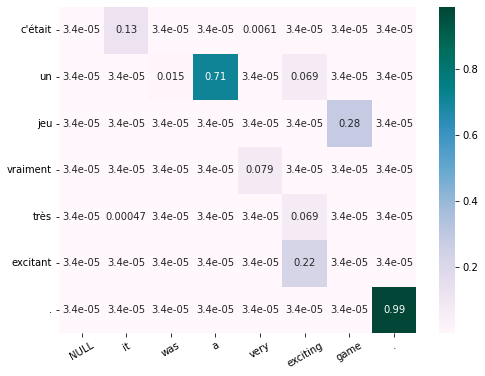

In [15]:
plt.figure(figsize=(8, 6))
plt.rc('font', size=10) 
en = "NULL it was a very exciting game .".split()
fr = "c'était un jeu vraiment très excitant .".split()
visualize_alignment(en, fr, hard_t)

## Soft EM algorithm

### Question 5 (8 points)
1. Implement ``soft_EM`` function which runs one ``Expectation/Maximization`` iteration.
2. Run the training code

In [16]:
def soft_EM(en_sents, fr_sents, t):
    '''
    One 'Expectation', 'Maximization' iteration.
    params:
        en_sents: List[List[str]]
        fr_sents: List[List[str]]
        t: Dict() --- translation probability dictionary from last iteration
        
    return:
        new_t: Dict() --- updated parameters, dictionary
    '''
    new_t = t
    ### YOUR CODE HERE
    
    # Expectation
    
    counter = defaultdict(lambda:defaultdict(lambda:0))
    
    for en_words, fr_words in zip(en_sents, fr_sents):
        for fr in fr_words:
            t_temp = []
            for en in en_words:
                t_temp.append(t[en, fr])
            _sum = np.sum(t_temp)
            
            for en in en_words:
                counter[en][fr] += t[(en, fr)] / _sum
    
    # Maximization
    
    for en, fr in counter.items():
        sum_en = 0
        for f, count in fr.items():
            sum_en += count
        for f, count in fr.items():
#             sum_ef = count
            new_t[(en, f)] = count / sum_en 

    ### END OF YOUR CODE
    return new_t

Let us check the algorithm first using the objective value.

In [17]:
############################################################
# Randomly initialized the probabilities under the contraint
############################################################
soft_t = init(align_counts)
    
##################
# Hard EM training
##################
iteration = 0
while iteration < 15:
    
    logp = corpus_log_prob(english_sents, french_sents, soft_t)    
    soft_t = soft_EM(english_sents, french_sents, soft_t)  
    print(f"Iteration: {iteration+1} Objective Function: {round(logp, 5)}")
    iteration += 1

Iteration: 1 Objective Function: -5666001.63189
Iteration: 2 Objective Function: -2789609.12719
Iteration: 3 Objective Function: -1984223.37994
Iteration: 4 Objective Function: -1752281.10315
Iteration: 5 Objective Function: -1669277.36277
Iteration: 6 Objective Function: -1630095.29424
Iteration: 7 Objective Function: -1608401.61802
Iteration: 8 Objective Function: -1595262.22748
Iteration: 9 Objective Function: -1586616.05157
Iteration: 10 Objective Function: -1580320.27417
Iteration: 11 Objective Function: -1575268.16842
Iteration: 12 Objective Function: -1570983.43877
Iteration: 13 Objective Function: -1567364.68429
Iteration: 14 Objective Function: -1564437.83047
Iteration: 15 Objective Function: -1562173.51609


### Visualization

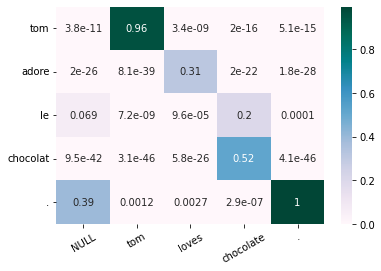

In [18]:
en = "NULL tom loves chocolate .".split()
fr = "tom adore le chocolat .".split()
visualize_alignment(en, fr, soft_t)

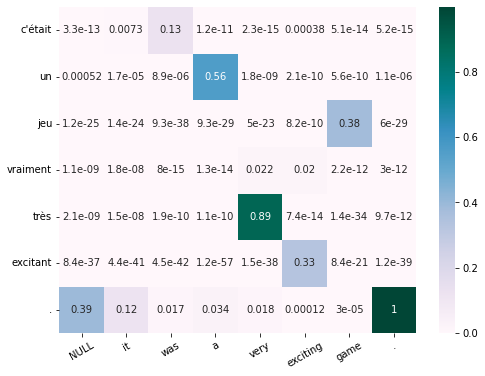

In [19]:
plt.figure(figsize=(8,6))
en = "NULL it was a very exciting game .".split()
fr = "c'était un jeu vraiment très excitant .".split()
visualize_alignment(en, fr, soft_t)